Sprites shape: (89400, 16, 16, 3)
Labels shape before conversion: (89400,)

Label distribution:
Label 0: 8000 images
Label 1: 32400 images
Label 2: 6000 images
Label 3: 35000 images
Label 4: 8000 images
Total images for label 3: 35000


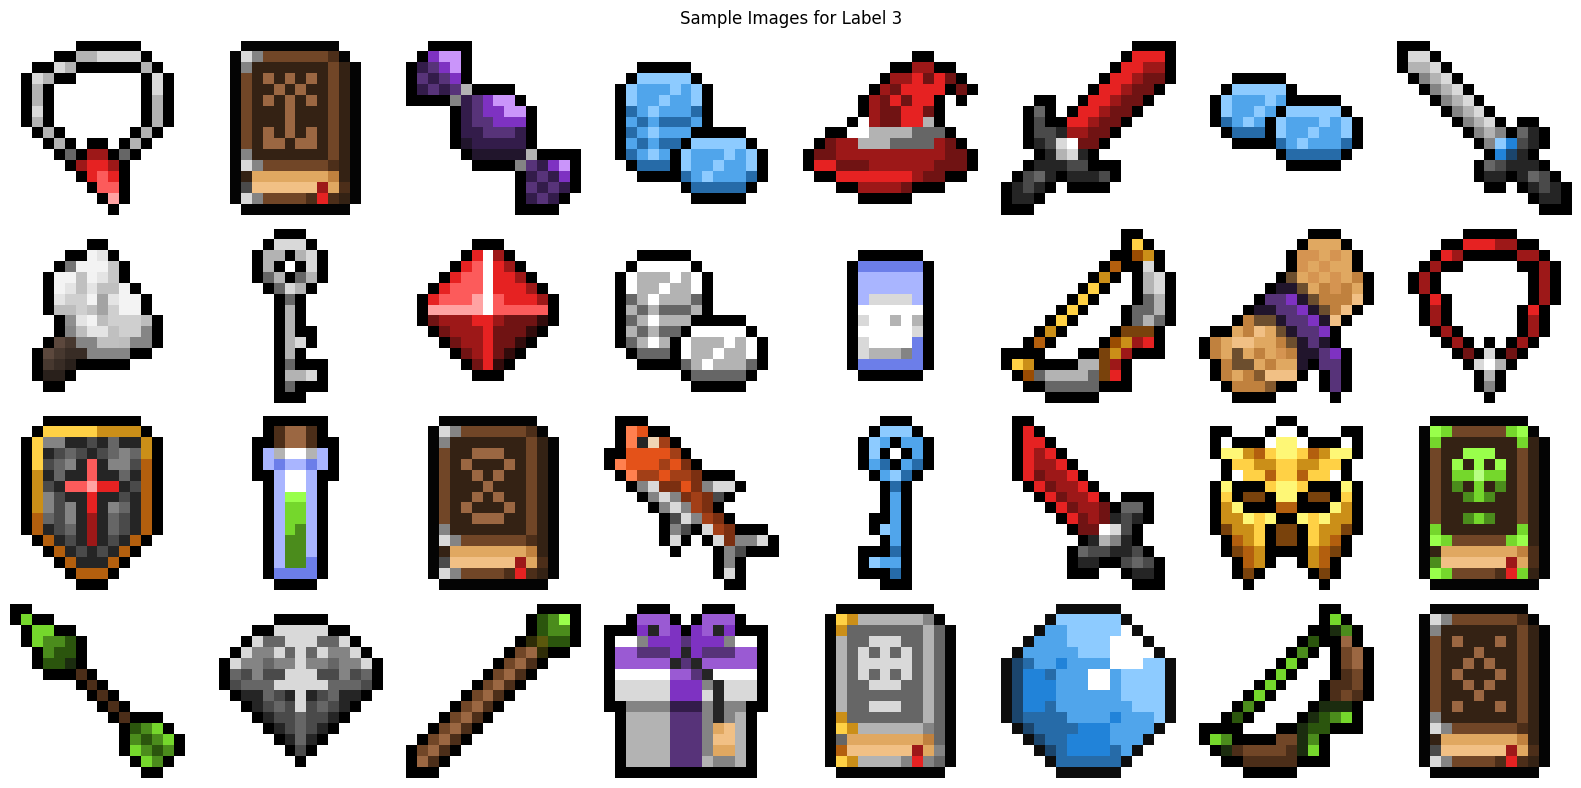

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import io

def load_data_from_zip(zip_path):
    with ZipFile(zip_path, 'r') as zf:
        # Load sprites array
        with zf.open('sprites.npy') as f:
            sprites = np.load(io.BytesIO(f.read()))
        
        # Load labels array
        with zf.open('sprites_labels.npy') as f:
            labels = np.load(io.BytesIO(f.read()))
    
    # Convert one-hot encoded labels to class indices
    if len(labels.shape) > 1 and labels.shape[1] > 1:  # Check if one-hot encoded
        labels = np.argmax(labels, axis=1)
    
    return sprites, labels

def plot_label_samples(sprites, labels, label_num, num_samples=32):
    # Get indices for the specified label
    label_indices = np.where(labels == label_num)[0]
    
    print(f"Total images for label {label_num}: {len(label_indices)}")
    
    # Randomly select num_samples indices
    if len(label_indices) > num_samples:
        sample_indices = np.random.choice(label_indices, num_samples, replace=False)
    else:
        sample_indices = label_indices
        print(f"Warning: Only {len(label_indices)} images available for label {label_num}")
    
    # Create a grid of subplots (4x8)
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    fig.suptitle(f'Sample Images for Label {label_num}')
    
    # Plot each image
    for idx, ax in enumerate(axes.flat):
        if idx < len(sample_indices):
            ax.imshow(sprites[sample_indices[idx]])
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the data
sprites, labels = load_data_from_zip('../data/raw/archive.zip')

# Print shapes to understand the data structure
print("Sprites shape:", sprites.shape)
print("Labels shape before conversion:", labels.shape)

# Get unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)
print("\nLabel distribution:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} images")

# Example usage:
plot_label_samples(sprites, labels, 3)  # Plot 32 samples from label 0

# Dataloader

In [1]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image

class PixelArtDataset(Dataset):
    """Dataset for pixel art sprites and their labels."""

    def __init__(self, 
                 data_path: Path,
                 transform=None,
                 label_subset=None,  # Optional: filter for specific label indices
                 calculate_stats=False
                ) -> None:
        """
        Initialize the dataset.
        
        Args:
            data_path: Path to the data folder containing labels.csv and images/images/*.jpg
            transform: Optional transforms to be applied on images
            label_subset: Optional list of indices to include (0-4 for the 5 categories)
            calculate_stats: Whether to recalculate dataset statistics
        """
        self.data_path = Path(data_path)
        self.transform = transform
        
        # Load labels from CSV
        self.labels_df = pd.read_csv(self.data_path / "labels.csv")
        
        # Convert string representation of arrays to numpy arrays
        self.labels_df['Label'] = self.labels_df['Label'].apply(
            lambda x: np.array([float(n) for n in x.strip('[]').split()])
        )
        
        # Filter by label subset if specified
        if label_subset is not None:
            # For one-hot encoded labels, we need to check the specific indices
            mask = self.labels_df['Label'].apply(
                lambda x: any(x[i] == 1.0 for i in label_subset)
            )
            self.labels_df = self.labels_df[mask].reset_index(drop=True)
        
        # Build image paths - using Image Index to construct filenames
        # Update the image path construction in the __init__ method:
        self.image_paths = [
            self.data_path / "images" / "images" / f"image_{idx-1}.JPEG"
            for idx in self.labels_df['Image Index']
        ]
        
        # Calculate statistics if needed
        if calculate_stats:
            self.mean, self.std = self.calculate_statistics()
        
        # Set default transform if none provided
        if self.transform is None:
            self.transform = self.get_default_transforms()
            
        # Print dataset info
        print(f"Loaded dataset with {len(self.image_paths)} sprites")
        label_counts = self.get_label_distribution()
        print("Label distribution:")
        for idx, count in enumerate(label_counts):
            print(f"Category {idx}: {count} images")

    def get_label_distribution(self):
        """Calculate the distribution of labels in the dataset."""
        # Sum up one-hot vectors to get counts for each category
        return np.sum(np.stack(self.labels_df['Label'].values), axis=0)

    def calculate_statistics(self):
        """Calculate dataset mean and std."""
        print("Calculating dataset statistics...")
        
        pixel_sum = torch.zeros(3)
        pixel_sq_sum = torch.zeros(3)
        num_pixels = 0

        for img_path in self.image_paths:
            img = Image.open(img_path)
            img_tensor = transforms.ToTensor()(img)
            
            pixel_sum += img_tensor.sum(dim=[1, 2])
            pixel_sq_sum += (img_tensor ** 2).sum(dim=[1, 2])
            num_pixels += img_tensor.shape[1] * img_tensor.shape[2]

        mean = pixel_sum / num_pixels
        std = torch.sqrt(pixel_sq_sum/num_pixels - mean**2)
        
        return mean.numpy(), std.numpy()

    def __len__(self) -> int:
        """Return the length of the dataset."""
        return len(self.image_paths)

    def __getitem__(self, index: int):
        """Return a given sample from the dataset."""
        # Load image
        img_path = self.image_paths[index]
        image = Image.open(img_path)
        
        # Get one-hot encoded label
        label = torch.tensor(self.labels_df.iloc[index]['Label'], dtype=torch.float)
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
        
        return {
            "pixel_values": image,
            "label": label
        }

    def get_default_transforms(self):
        """Return transforms using calculated dataset statistics."""
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=self.mean if hasattr(self, 'mean') else [0.5, 0.5, 0.5],
                std=self.std if hasattr(self, 'std') else [0.5, 0.5, 0.5]
            )
        ])

In [2]:
# First time setup - calculate statistics
dataset = PixelArtDataset(
    data_path="../data/processed",
    calculate_stats=True,
    label_subset=[3]  # Only items (label 3)
)

# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    num_workers=0
)

Calculating dataset statistics...
Loaded dataset with 35000 sprites
Label distribution:
Category 0: 0.0 images
Category 1: 0.0 images
Category 2: 0.0 images
Category 3: 35000.0 images
Category 4: 0.0 images


# Model

In [3]:
import torch
import torch.nn as nn
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from diffusers.optimization import get_scheduler
from tqdm.notebook import tqdm

class PixelArtDiffusion:
    def __init__(
        self,
        image_size=16,
        num_channels=3,
        num_train_timesteps=500,
        batch_size=64,
        num_epochs=100,
        learning_rate=1e-4,
    ):
        self.image_size = image_size
        self.num_channels = num_channels
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        
        # Initialize the UNet2DModel - lighter configuration
        self.model = UNet2DModel(
            sample_size=16,           # Your 16x16 images
            in_channels=3,            # RGB
            out_channels=3,
            layers_per_block=2,       # Keeping it light
            block_out_channels=(64, 128),  # Progressive feature scaling but smaller
            down_block_types=("DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D")
        )
        
        # Initialize noise scheduler
        self.noise_scheduler = DDPMScheduler(
            num_train_timesteps=num_train_timesteps,
            beta_start=1e-4,
            beta_end=0.02,
            beta_schedule="linear",
            clip_sample=True
        )
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        print(f"Using device: {self.device}")

    def train(self, dataloader, run_name="pixel_art_diffusion"):
        """Train the model"""
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=0.01,
            eps=1e-8
        )
        
        lr_scheduler = get_scheduler(
            name="cosine",
            optimizer=optimizer,
            num_warmup_steps=1000,
            num_training_steps=len(dataloader) * self.num_epochs
        )

        print(f"Starting training for {self.num_epochs} epochs...")
        
        # Main training loop with tqdm
        for epoch in tqdm(range(self.num_epochs), desc="Training epochs"):
            self.model.train()
            total_loss = 0
            
            for batch in dataloader:
                clean_images = batch["pixel_values"].to(self.device)
                
                # Sample noise and timesteps
                noise = torch.randn_like(clean_images)
                timesteps = torch.randint(
                    0,
                    self.noise_scheduler.config.num_train_timesteps,
                    (clean_images.shape[0],),
                    device=self.device
                )
                
                # Add noise according to schedule
                noisy_images = self.noise_scheduler.add_noise(
                    clean_images,
                    noise,
                    timesteps
                )
                
                # Predict noise
                noise_pred = self.model(noisy_images, timesteps).sample
                
                # Calculate loss
                loss = nn.functional.mse_loss(noise_pred, noise)
                total_loss += loss.item()
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")
            
            if epoch % 10 == 0:
                self.save_checkpoint(f"checkpoint-epoch-{epoch}.pt")

    def generate_samples(self, num_samples=16):
        """Generate new pixel art samples"""
        self.model.eval()
        
        # Start from random noise
        sample = torch.randn(
            (num_samples, self.num_channels, self.image_size, self.image_size),
            device=self.device
        )
        
        print("Generating samples...")
        # Denoise gradually
        for t in self.noise_scheduler.timesteps:
            if t % 100 == 0:
                print(f"Denoising step {t}")
            with torch.no_grad():
                noise_pred = self.model(sample, t).sample
                step_output = self.noise_scheduler.step(
                    noise_pred,
                    t,
                    sample
                )
                sample = step_output.prev_sample
                
                # Apply pixel art quantization periodically
                if t % 100 == 0:
                    sample = self.quantize_to_pixel_art(sample)
        
        # Final quantization
        sample = self.quantize_to_pixel_art(sample)
        return sample

    def analyze_color_distribution(self, dataloader):
        """Analyze the unique colors used in the dataset."""
        print("Analyzing color distribution in dataset...")
        
        # Create lists to store unique values for each channel
        r_values = set()
        g_values = set()
        b_values = set()
        
        for batch in dataloader:
            images = batch["pixel_values"]
            # Convert to [0,1] range if in [-1,1]
            if images.min() < 0:
                images = (images + 1) / 2
                
            # Collect unique values per channel
            r_values.update(images[:, 0, :, :].unique().tolist())
            g_values.update(images[:, 1, :, :].unique().tolist())
            b_values.update(images[:, 2, :, :].unique().tolist())
        
        print(f"Unique values per channel:")
        print(f"R: {len(r_values)} values")
        print(f"G: {len(g_values)} values")
        print(f"B: {len(b_values)} values")
        
        # Store the actual values
        self.color_levels = {
            'r': sorted(list(r_values)),
            'g': sorted(list(g_values)),
            'b': sorted(list(b_values))
        }
        return self.color_levels

    def quantize_to_pixel_art(self, sample, use_dataset_colors=True):
        """Quantize the sample to match the dataset's color palette."""
        if not hasattr(self, 'color_levels'):
            print("Warning: No color analysis performed. Falling back to default quantization.")
            return self._default_quantize(sample)
            
        # Convert to [0,1] range
        sample = (sample + 1) / 2
        
        # Quantize each channel separately using the analyzed levels
        for i, channel in enumerate(['r', 'g', 'b']):
            levels = torch.tensor(self.color_levels[channel], device=sample.device)
            channel_data = sample[:, i:i+1]
            
            # For each pixel, find the closest value in our color levels
            distances = torch.abs(channel_data.unsqueeze(-1) - levels)
            closest_level_idx = torch.argmin(distances, dim=-1)
            sample[:, i:i+1] = levels[closest_level_idx]
        
        # Convert back to [-1,1] range
        sample = sample * 2 - 1
        return sample

    def _default_quantize(self, sample, num_colors=16):
        """Original quantization method as fallback."""
        sample = (sample + 1) / 2
        sample = torch.floor(sample * (num_colors - 1)) / (num_colors - 1)
        sample = sample * 2 - 1
        return sample

    def save_checkpoint(self, path):
        """Save model checkpoint"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'scheduler_config': self.noise_scheduler.config
        }, path)
        print(f"Saved checkpoint to {path}")

    def load_checkpoint(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.noise_scheduler = DDPMScheduler.from_config(checkpoint['scheduler_config'])
        print(f"Loaded checkpoint from {path}")

In [15]:
# Initialize model
model = PixelArtDiffusion(
    image_size=16,
    num_channels=3,
    batch_size=256,
    num_epochs=50,
    num_train_timesteps=100
)

# Run color analysis before training
model.analyze_color_distribution(dataloader)

# Train
model.train(dataloader)


Using device: cuda
Analyzing color distribution in dataset...
Unique values per channel:
R: 256 values
G: 256 values
B: 256 values
Starting training for 50 epochs...


Training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Average Loss = 0.9318
Saved checkpoint to checkpoint-epoch-0.pt
Epoch 1: Average Loss = 0.4967
Epoch 2: Average Loss = 0.3383
Epoch 3: Average Loss = 0.2658
Epoch 4: Average Loss = 0.2199
Epoch 5: Average Loss = 0.1879
Epoch 6: Average Loss = 0.1661
Epoch 7: Average Loss = 0.1487
Epoch 8: Average Loss = 0.1328
Epoch 9: Average Loss = 0.1234
Epoch 10: Average Loss = 0.1149
Saved checkpoint to checkpoint-epoch-10.pt
Epoch 11: Average Loss = 0.1080
Epoch 12: Average Loss = 0.1007
Epoch 13: Average Loss = 0.0951
Epoch 14: Average Loss = 0.0924
Epoch 15: Average Loss = 0.0879
Epoch 16: Average Loss = 0.0843
Epoch 17: Average Loss = 0.0804
Epoch 18: Average Loss = 0.0792
Epoch 19: Average Loss = 0.0750
Epoch 20: Average Loss = 0.0729
Saved checkpoint to checkpoint-epoch-20.pt
Epoch 21: Average Loss = 0.0705
Epoch 22: Average Loss = 0.0683
Epoch 23: Average Loss = 0.0656
Epoch 24: Average Loss = 0.0644
Epoch 25: Average Loss = 0.0618
Epoch 26: Average Loss = 0.0604
Epoch 27: Average 

Generating samples...
Denoising step 0
Saved visualization to generated_samples.png


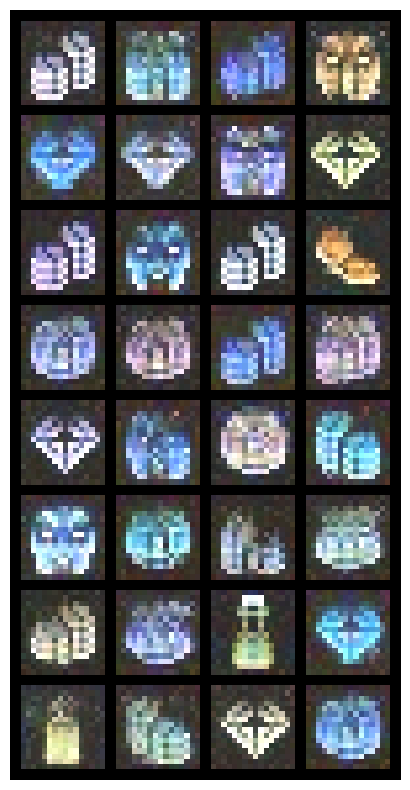

In [25]:
def visualize_samples(samples, save_path=None):
    """
    Visualize and optionally save generated samples in a grid
    
    Args:
        samples: Tensor of shape (batch_size, channels, height, width)
        save_path: Optional path to save the visualization
    """
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    
    # Ensure the samples are in CPU and correct range
    samples = samples.cpu()
    
    # Create a grid of images
    grid = make_grid(samples, nrow=4, normalize=True, value_range=(-1, 1))
    
    # Convert to numpy and transpose to correct format (H,W,C)
    grid = grid.permute(1, 2, 0).numpy()
    
    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        print(f"Saved visualization to {save_path}")
    
    plt.show()

# Generate samples
samples = model.generate_samples(num_samples=32)

visualize_samples(samples, "generated_samples.png")  # Optional save path

In [4]:
# Generate samples
samples = model.generate_samples(num_samples=32)

visualize_samples(samples, "generated_samples.png")  # Optional save path

In [5]:
# Initialize model
model = PixelArtDiffusion(
    image_size=16,
    num_channels=3,
    batch_size=256,
    num_epochs=50,
    num_train_timesteps=100
)

# Run color analysis before training
model.analyze_color_distribution(dataloader)

Using device: cuda
Analyzing color distribution in dataset...
Unique values per channel:
R: 256 values
G: 256 values
B: 256 values


{'r': [0.1554354429244995,
  0.16205686330795288,
  0.16867831349372864,
  0.175299733877182,
  0.18192118406295776,
  0.18854260444641113,
  0.1951640546321869,
  0.20178547501564026,
  0.20840689539909363,
  0.21502834558486938,
  0.22164976596832275,
  0.2282712161540985,
  0.23489263653755188,
  0.24151408672332764,
  0.248135507106781,
  0.2547569274902344,
  0.2613784074783325,
  0.2679998278617859,
  0.27462124824523926,
  0.281242698431015,
  0.28786414861679077,
  0.29448556900024414,
  0.3011069893836975,
  0.3077284097671509,
  0.31434985995292664,
  0.3209713101387024,
  0.32759273052215576,
  0.33421415090560913,
  0.3408355712890625,
  0.34745702147483826,
  0.354078471660614,
  0.3606998920440674,
  0.36732134222984314,
  0.3739427924156189,
  0.38056421279907227,
  0.38718563318252563,
  0.3938070833683014,
  0.40042850375175476,
  0.4070499539375305,
  0.4136713743209839,
  0.42029279470443726,
  0.426914244890213,
  0.4335356652736664,
  0.44015711545944214,
  0.44677

In [6]:
model.load_checkpoint("checkpoint-epoch-50.pt")

Loaded checkpoint from checkpoint-epoch-50.pt


C:\Users\gtoft\AppData\Local\Temp\ipykernel_26132\1375379546.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Generating samples...
Denoising step 0


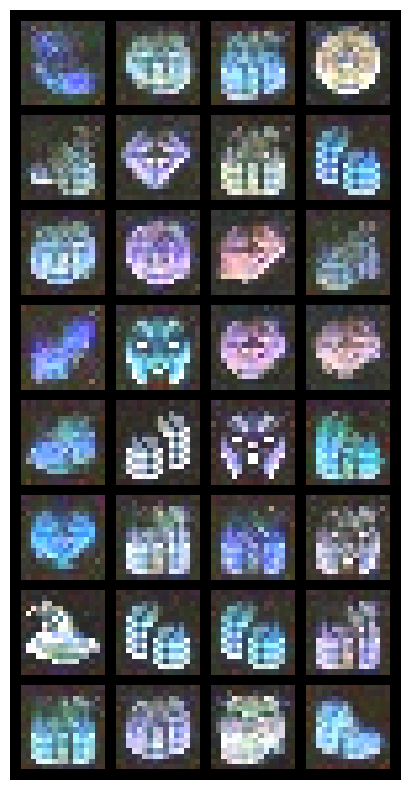

In [7]:
# Generate samples
samples = model.generate_samples(num_samples=32)

visualize_samples(samples)

# 2nd attempt

In [71]:
import torch
import torch.nn as nn
from diffusers import DDPMScheduler, UNet2DModel

class PixelArtDiffusion:
    def __init__(
        self,
        image_size=16,
        num_channels=3,
        num_train_timesteps=500,
        base_channels=128,
    ):
        self.image_size = image_size
        self.num_channels = num_channels
        
        # Enhanced UNet configuration
        self.model = UNet2DModel(
            sample_size=image_size,
            in_channels=num_channels,
            out_channels=num_channels,
            layers_per_block=3,  # More layers per block
            block_out_channels=(base_channels, base_channels*2, base_channels*4),  # Progressive scaling
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",  # Added attention
                "AttnDownBlock2D",  # Added attention
            ),
            up_block_types=(
                "AttnUpBlock2D",  # Added attention
                "AttnUpBlock2D",   # Added attention
                "UpBlock2D",
            ),
            dropout=0.1,  # Added dropout for regularization
        )
        
        # Enhanced noise scheduler
        self.noise_scheduler = DDPMScheduler(
            num_train_timesteps=num_train_timesteps,
            beta_start=1e-4,
            beta_end=0.02,
            beta_schedule="scaled_linear",  # Better schedule
            clip_sample=True,
            prediction_type="epsilon",
        )
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        self.model.to(self.device)

    def generate_samples(self, num_samples=16):
        """Generate new pixel art samples"""
        self.model.eval()
        
        with torch.no_grad():
            # Start from random noise
            noise = torch.randn(
                (num_samples, self.num_channels, self.image_size, self.image_size),
                device=self.device
            )
            
            # Gradual denoising
            images = noise
            
            for t in self.noise_scheduler.timesteps:
                # Predict noise
                model_output = self.model(images, t).sample
                
                # Scheduler step
                scheduler_output = self.noise_scheduler.step(
                    model_output, t, images
                )
                
                images = scheduler_output.prev_sample
                
                # Apply pixel art quantization periodically
                if t % 100 == 0:
                    images = self.quantize_to_pixel_art(images)
            
            # Final quantization
            images = self.quantize_to_pixel_art(images)
            return images

    def quantize_to_pixel_art(self, images, num_colors=16):
        """Quantize the generated images to achieve pixel art style"""
        # Convert to [0,1] range
        images = (images + 1) / 2
        
        # Quantize to specified number of colors
        images = torch.floor(images * (num_colors - 1)) / (num_colors - 1)
        
        # Convert back to [-1,1] range
        images = images * 2 - 1
        return images

    def save_checkpoint(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'scheduler_config': self.noise_scheduler.config
        }, path)

    def load_checkpoint(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.noise_scheduler = DDPMScheduler.from_config(checkpoint['scheduler_config'])

In [76]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os

def train_model(
    model,
    dataloader,
    num_epochs=100,
    learning_rate=1e-4,
    weight_decay=0.01,
    gradient_clip_val=1.0,
    save_interval=10,
    save_dir="checkpoints"
):
    """Enhanced training loop for PixelArtDiffusion model"""
    optimizer = torch.optim.AdamW(
        model.model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # Enhanced learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(dataloader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch in dataloader:
            images = batch['pixel_values'].to(model.device)
            
            # Sample random noise
            noise = torch.randn_like(images)
            batch_size = images.shape[0]
            
            # Sample timesteps uniformly
            timesteps = torch.randint(
                0,
                model.noise_scheduler.config.num_train_timesteps,
                (batch_size,),
                device=model.device
            )
            
            # Add noise to images
            noisy_images = model.noise_scheduler.add_noise(images, noise, timesteps)
            
            # Predict noise
            noise_pred = model.model(noisy_images, timesteps).sample
            
            # Calculate loss
            loss = F.mse_loss(noise_pred, noise)
            
            # Optimize
            optimizer.zero_grad()
            loss.backward()
            
            if gradient_clip_val > 0:
                torch.nn.utils.clip_grad_norm_(
                    model.model.parameters(),
                    gradient_clip_val
                )
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        # Print epoch summary
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")
        
        # Save checkpoint
        if (epoch + 1) % save_interval == 0:
            os.makedirs(save_dir, exist_ok=True)
            checkpoint_path = f"{save_dir}/model_epoch_{epoch+1}.pt"
            model.save_checkpoint(checkpoint_path)
            print(f"Saved checkpoint to {checkpoint_path}")

In [ ]:
# Initialize enhanced model
model = PixelArtDiffusion(
    image_size=16,
    num_channels=3,
    num_train_timesteps=500,
    base_channels=128  # This will be scaled up in the progressive channel scaling
)

# Train with enhanced training loop
train_model(
    model=model,
    dataloader=dataloader,
    num_epochs=100,
    learning_rate=1e-4,
    save_interval=10,
    save_dir='./checkpoints'
)

Using device: cuda
Starting training for 100 epochs...


Training:   0%|          | 0/100 [00:00<?, ?it/s]